In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams.update({'font.size': 24})
plt.rcParams.update({'font.weight': 'bold'})

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None



In [2]:
aloha = pd.read_csv('results/aloha.csv', encoding='latin-1', converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray})


In [3]:
aloha.head()


,run,type,module,name,attrname,attrvalue,value,count,sumweights,mean,stddev,min,max,binedges,binvalues
0,MAM10-MAMRELAY-23-20200918-03:06:23-266634,runattr,NaN,NaN,configname,MAM10-MAMRELAY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
1,MAM10-MAMRELAY-23-20200918-03:06:23-266634,runattr,NaN,NaN,datetime,20200918-03:06:23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
2,MAM10-MAMRELAY-23-20200918-03:06:23-266634,runattr,NaN,NaN,experiment,MAM10-MAMRELAY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
3,MAM10-MAMRELAY-23-20200918-03:06:23-266634,runattr,NaN,NaN,inifile,omnetpp.ini,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
4,MAM10-MAMRELAY-23-20200918-03:06:23-266634,runattr,NaN,NaN,iterationvars,"$delta=1000, $speedMps=14",NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None


In [4]:
allAttrs = aloha[(aloha.type == 'itervar')]['attrname'].unique()
allAttrs.sort()
allAttrs

array(['delta', 'speedMps'], dtype=object)

In [5]:
allRelayModes = aloha[(aloha['attrname'].str.contains('.app[0].relayMode', na=False, regex=False))]['attrvalue'].unique()
allRelayModes.sort()
allRelayModes

array(['"BMesh"', '"MAM"'], dtype=object)

In [6]:
allSpeeds = aloha[(aloha.attrname == 'speedMps')]['attrvalue'].unique()
allSpeeds.sort()
allSpeeds

array([2.0, 6.0, 14.0], dtype=object)

In [7]:
allDeltas = aloha[(aloha.attrname == 'delta')]['attrvalue'].unique()
allDeltas = allDeltas[allDeltas <= 500]
allDeltas = allDeltas[allDeltas != 2]
allDeltas.sort()
allDeltas

array([0.0, 5.0, 10.0, 20.0, 50.0, 100.0, 500.0], dtype=object)

In [8]:
dataByRun = aloha.groupby(['run'])
dataByRun.size()

run
MAM10-BMRELAY-0-20200918-03:04:53-266586      2553
MAM10-BMRELAY-1-20200918-03:04:58-266586      2552
MAM10-BMRELAY-2-20200918-03:05:01-266586      2551
MAM10-MAMRELAY-0-20200918-03:05:04-266634     2553
MAM10-MAMRELAY-1-20200918-03:05:08-266634     2552
                                             ...  
MAM50-MAMRELAY-5-20200918-02:41:17-263933    11593
MAM50-MAMRELAY-6-20200918-02:41:47-263933    11594
MAM50-MAMRELAY-7-20200918-02:42:26-263933    11594
MAM50-MAMRELAY-8-20200918-02:43:11-263933    11593
MAM50-MAMRELAY-9-20200918-02:43:38-263933    11595
Length: 117, dtype: int64

In [9]:

def findBluetoothRelayRun(speed, configName):
    def testA(x):
        bmeshMatch = x[(x['attrname'].str.contains('.app[0].relayMode', na=False, regex=False))]['attrvalue'].iloc[0] == '"BMesh"'
        speedMatch = x[(x.attrname == 'speedMps')]['attrvalue'].iloc[0] == speed
        configNameMatch = x[(x.attrname == 'configname')]['attrvalue'].iloc[0] == configName
    
        return bmeshMatch & speedMatch & configNameMatch

    s = pd.Series(dataByRun.apply(testA))
    s = s[s == True]
    if len(s) == 0:
        raise Exception("Bluetooth Relay run not found for speed=" + str(speed) + " configName=" + configName)
    if len(s) > 1:
        raise Exception("Bluetooth Relay run duplicate for speed=" + str(speed) + " configName=" + configName)
    return s.index[0]

findBluetoothRelayRun(speed=6, configName='MAM10-BMRELAY')



'MAM10-BMRELAY-1-20200918-03:04:58-266586'

In [10]:

def findMAMRelayRun(speed, delta, configName):
    def testA(x):
        bmeshMatch = x[(x['attrname'].str.contains('.app[0].relayMode', na=False, regex=False))]['attrvalue'].iloc[0] == '"MAM"'
        speedMatch = x[(x.attrname == 'speedMps')]['attrvalue'].iloc[0] == speed
        deltaMatch = x[(x.attrname == 'delta')]['attrvalue'].iloc[0] == delta
        configNameMatch = x[(x.attrname == 'configname')]['attrvalue'].iloc[0] == configName
    
        return bmeshMatch & speedMatch & deltaMatch & configNameMatch

    s = pd.Series(dataByRun.apply(testA))
    s = s[s == True]
    if len(s) == 0:
        raise Exception("MAM Relay run not found for speed=" + str(speed) + " delta=" + str(delta) + " configName=" + configName)
    if len(s) > 1:
        raise Exception("MAM Relay run duplicate for speed=" + str(speed) + " delta=" + str(delta) + " configName=" + configName)
    return s.index[0]

findMAMRelayRun(speed=2, delta=5, configName='MAM50-MAMRELAY')


'MAM50-MAMRELAY-6-20200918-02:41:47-263933'

In [11]:
def getRunData(run):
    return aloha[aloha.run == run]

def getCollectorRunScalars(run):
    runData = aloha[aloha.run == run]
    runData = runData[(runData.type=='scalar')]
    return runData[runData['module'].str.contains('collector1.app')]

getRunData(findBluetoothRelayRun(speed=6, configName='MAM10-BMRELAY'))

,run,type,module,name,attrname,attrvalue,value,count,sumweights,mean,stddev,min,max,binedges,binvalues
397,MAM10-BMRELAY-1-20200918-03:04:58-266586,runattr,NaN,NaN,configname,MAM10-BMRELAY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
398,MAM10-BMRELAY-1-20200918-03:04:58-266586,runattr,NaN,NaN,datetime,20200918-03:04:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
399,MAM10-BMRELAY-1-20200918-03:04:58-266586,runattr,NaN,NaN,experiment,MAM10-BMRELAY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
400,MAM10-BMRELAY-1-20200918-03:04:58-266586,runattr,NaN,NaN,inifile,omnetpp.ini,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
401,MAM10-BMRELAY-1-20200918-03:04:58-266586,runattr,NaN,NaN,iterationvars,"$delta=0, $speedMps=6",NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580370,MAM10-BMRELAY-1-20200918-03:04:58-266586,histogram,MAM10.collector1.app[0],endToEndDelay:histogram,NaN,None,NaN,3162.0,NaN,0.018987,0.015915,0.0,0.086488,"[0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006...","[200.0, 46.0, 139.0, 174.0, 84.0, 103.0, 123.0..."
580371,MAM10-BMRELAY-1-20200918-03:04:58-266586,attr,MAM10.collector1.app[0],endToEndDelay:histogram,interpolationmode,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
580372,MAM10-BMRELAY-1-20200918-03:04:58-266586,attr,MAM10.collector1.app[0],endToEndDelay:histogram,source,dataAge(packetReceived),NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
580373,MAM10-BMRELAY-1-20200918-03:04:58-266586,attr,MAM10.collector1.app[0],endToEndDelay:histogram,title,"end-to-end delay, histogram",NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None


In [12]:
aloha.iloc[1200:1205]


,run,type,module,name,attrname,attrvalue,value,count,sumweights,mean,stddev,min,max,binedges,binvalues
1200,MAM10-MAMRELAY-28-20200918-03:06:40-266634,runattr,NaN,NaN,seedset,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
1201,MAM10-MAMRELAY-28-20200918-03:06:40-266634,itervar,NaN,NaN,delta,10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
1202,MAM10-MAMRELAY-28-20200918-03:06:40-266634,itervar,NaN,NaN,speedMps,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
1203,MAM10-MAMRELAY-28-20200918-03:06:40-266634,param,NaN,NaN,*.host*.app[0].relayMode,"""MAM""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
1204,MAM10-MAMRELAY-28-20200918-03:06:40-266634,param,NaN,NaN,*.host*.app[0].delta,10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None


In [13]:
aloha.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613267 entries, 0 to 613266
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   run         613267 non-null  object 
 1   type        613267 non-null  object 
 2   module      603940 non-null  object 
 3   name        603940 non-null  object 
 4   attrname    425262 non-null  object 
 5   attrvalue   425262 non-null  object 
 6   value       174493 non-null  float64
 7   count       13512 non-null   float64
 8   sumweights  0 non-null       float64
 9   mean        8271 non-null    float64
 10  stddev      8271 non-null    float64
 11  min         8271 non-null    float64
 12  max         8271 non-null    float64
 13  binedges    10950 non-null   object 
 14  binvalues   10950 non-null   object 
dtypes: float64(7), object(8)
memory usage: 70.2+ MB


In [14]:
aloha.describe()

,value,count,sumweights,mean,stddev,min,max
count,1.744930e+05,13512.000000,0.0,8271.000000,8271.000000,8.271000e+03,8271.000000
mean,6.363201e+03,1606.396388,NaN,14.138443,34.163754,3.968049e-01,422.758677
std,1.368043e+05,2252.848601,NaN,57.026189,259.914252,1.499135e+00,4255.525333
min,-1.476475e+00,0.000000,NaN,0.000000,0.000000,0.000000e+00,0.000000
25%,0.000000e+00,0.000000,NaN,0.001003,0.007055,0.000000e+00,0.129217
50%,1.000000e+00,607.000000,NaN,0.031684,0.157984,5.268740e-215,1.000000
75%,3.670000e+02,2487.000000,NaN,11.162332,8.892453,1.841660e-01,39.120166
max,8.962071e+06,13535.000000,NaN,1011.435918,7352.731642,1.437791e+01,79489.688726


In [15]:
scalars = aloha[(aloha.type=='scalar')]
scalars.head()


,run,type,module,name,attrname,attrvalue,value,count,sumweights,mean,stddev,min,max,binedges,binvalues
9327,MAM10-BMRELAY-2-20200918-03:05:01-266586,scalar,MAM10.radioMedium.propagation,Arrival computation count,NaN,None,77000.0,NaN,NaN,NaN,NaN,NaN,NaN,None,None
9328,MAM10-BMRELAY-2-20200918-03:05:01-266586,scalar,MAM10.radioMedium,transmission count,NaN,None,7700.0,NaN,NaN,NaN,NaN,NaN,NaN,None,None
9329,MAM10-BMRELAY-2-20200918-03:05:01-266586,scalar,MAM10.radioMedium,signal send count,NaN,None,77000.0,NaN,NaN,NaN,NaN,NaN,NaN,None,None
9330,MAM10-BMRELAY-2-20200918-03:05:01-266586,scalar,MAM10.radioMedium,reception computation count,NaN,None,77000.0,NaN,NaN,NaN,NaN,NaN,NaN,None,None
9331,MAM10-BMRELAY-2-20200918-03:05:01-266586,scalar,MAM10.radioMedium,interference computation count,NaN,None,180999.0,NaN,NaN,NaN,NaN,NaN,NaN,None,None


In [16]:
runPrefix = 'MAM50-BMRELAY-0'
run2Prefix = 'MAM50-MAMRELAY-6'

In [17]:
def getScalarSum(scalarName, runData):
    scalarData = runData[(runData.type=='scalar')]
    return scalarData[(scalarData.name==scalarName)]['value'].sum()

energyConsumptionSum = getScalarSum(scalarName='residualEnergyCapacity:last', 
                        runData=getRunData(findBluetoothRelayRun(speed=2, configName='MAM50-BMRELAY')))
energyConsumptionSum

-24.70769250360002

In [18]:
energyConsumption2Sum = getScalarSum(scalarName='residualEnergyCapacity:last', 
                        runData=getRunData(findMAMRelayRun(speed=2, delta=10, configName='MAM50-MAMRELAY')))
energyConsumption2Sum

-23.5886290953411

In [19]:
def getUniqueScalarValue(scalarName, scalarData):
    scalarValue = scalarData[(scalarData.name==scalarName)]['value']

    if len(scalarValue) > 1:
        raise Exception('Scalar ' + scalarName + ' is not unique on this dataframe')
    return scalarValue.iloc[0]

collectorPacketsReceived = getUniqueScalarValue(scalarName='packetReceived:count', 
                        scalarData=getCollectorRunScalars(findBluetoothRelayRun(speed=2, configName='MAM50-BMRELAY')))

'Packets received (BM 2): ' + str(collectorPacketsReceived)

'Packets received (BM 2): 2463.0'

In [20]:
collectorPacketsReceived2 = getUniqueScalarValue(scalarName='packetReceived:count', 
                        scalarData=getCollectorRunScalars(findMAMRelayRun(speed=2, delta=10, configName='MAM50-MAMRELAY')))

'Packets received (MAM 2 D5): ' + str(collectorPacketsReceived2)

'Packets received (MAM 2 D5): 2432.0'

In [21]:
dataPacketsSent = getScalarSum('data packets sent', getRunData(findBluetoothRelayRun(speed=2, configName='MAM50-BMRELAY')))
dataPacketsSent2 = getScalarSum('data packets sent', getRunData(findMAMRelayRun(speed=2, delta=10, configName='MAM50-MAMRELAY')))

'Data packets sent (BM 2): ' + str(dataPacketsSent) + ' / Data packets sent (MAM 2 D5): ' + str(dataPacketsSent2)

'Data packets sent (BM 2): 33070.0 / Data packets sent (MAM 2 D5): 13660.0'

In [22]:
'Data packets sent (' + run2Prefix + '): ' + str(dataPacketsSent2)

'Data packets sent (MAM50-MAMRELAY-6): 13660.0'

In [23]:
histograms = aloha[aloha.type=='histogram']
endToEndDelayHistograms = histograms[aloha.name=='realDataEndToEndDelay:histogram']
len(endToEndDelayHistograms)


<ipython-input-23-5a1b8474be2b>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  endToEndDelayHistograms = histograms[aloha.name=='realDataEndToEndDelay:histogram']


117

In [24]:
def getHistogramData(histogramName, runData):
    histograms = runData[runData.type == 'histogram']
    histogram = histograms[histograms.name == histogramName]
    if len(histogram) == 0:
        raise Exception('Histogram not found')
    if len(histogram) > 1:
        raise Exception('Histogram match not unique')
    return histogram.iloc[0]

hist = getHistogramData(histogramName='realDataEndToEndDelay:histogram', 
                        runData=getRunData(findBluetoothRelayRun(speed=2, configName='MAM50-BMRELAY')))
hist

run                    MAM50-BMRELAY-0-20200918-02:36:21-263755
type                                                  histogram
module                                  MAM50.collector1.app[0]
name                            realDataEndToEndDelay:histogram
attrname                                                    NaN
attrvalue                                                  None
value                                                       NaN
count                                                      1920
sumweights                                                  NaN
mean                                                     158.88
stddev                                                  38.2351
min                                                     1.01728
max                                                     199.132
binedges      [0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...
binvalues     [9.0, 18.0, 11.0, 17.0, 20.0, 0.0, 0.0, 0.0, 0...
Name: 587897, dtype: object

In [25]:
hist2 = getHistogramData(histogramName='realDataEndToEndDelay:histogram', 
                        runData=getRunData(findMAMRelayRun(speed=2, delta=10, configName='MAM50-MAMRELAY')))
hist2

run                   MAM50-MAMRELAY-9-20200918-02:43:38-263933
type                                                  histogram
module                                  MAM50.collector1.app[0]
name                            realDataEndToEndDelay:histogram
attrname                                                    NaN
attrvalue                                                  None
value                                                       NaN
count                                                      1967
sumweights                                                  NaN
mean                                                    149.436
stddev                                                  40.8078
min                                                      1.0144
max                                                     199.157
binedges      [0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0, 28.0, ...
binvalues     [12.0, 19.0, 16.0, 19.0, 15.0, 15.0, 6.0, 0.0,...
Name: 597227, dtype: object

In [26]:
hist2.binedges, hist2.binvalues

(array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
         88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.,
        132., 136., 140., 144., 148., 152., 156., 160., 164., 168., 172.,
        176., 180., 184., 188., 192., 196., 200.]),
 array([ 12.,  19.,  16.,  19.,  15.,  15.,   6.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0., 107.,  69.,  78.,  70.,  67.,
        101.,  79.,  98.,  59.,  64., 105.,  70.,  97.,  74.,  97.,  59.,
         88., 102.,  97.,  84., 113.,  87.]))

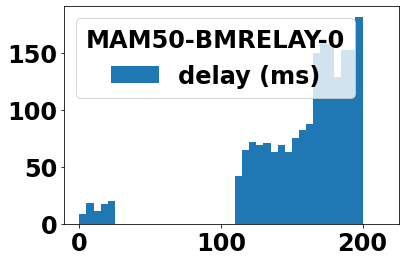

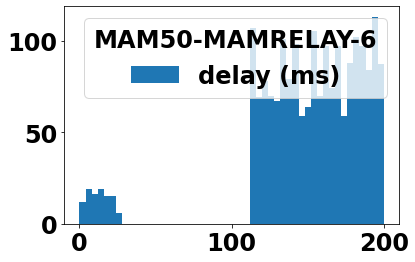

In [27]:

plt.hist(bins=hist.binedges, x=hist.binedges[:-1], weights=hist.binvalues, label="delay (ms)")
plt.legend(title=runPrefix)
plt.show()

plt.hist(bins=hist2.binedges, x=hist2.binedges[:-1], weights=hist2.binvalues, label="delay (ms)")
plt.legend(title=run2Prefix)
plt.show()

In [28]:
hist = endToEndDelayHistograms[endToEndDelayHistograms['run'].str.startswith(runPrefix, na=False)].iloc[0]
hist

run                    MAM50-BMRELAY-0-20200918-02:36:21-263755
type                                                  histogram
module                                  MAM50.collector1.app[0]
name                            realDataEndToEndDelay:histogram
attrname                                                    NaN
attrvalue                                                  None
value                                                       NaN
count                                                      1920
sumweights                                                  NaN
mean                                                     158.88
stddev                                                  38.2351
min                                                     1.01728
max                                                     199.132
binedges      [0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0,...
binvalues     [9.0, 18.0, 11.0, 17.0, 20.0, 0.0, 0.0, 0.0, 0...
Name: 587897, dtype: object

In [29]:
str(100-energyConsumption2Sum/energyConsumptionSum*100) + '% ' + run2Prefix + ' energy efficiency compared to ' + runPrefix

'4.5292105205529225% MAM50-MAMRELAY-6 energy efficiency compared to MAM50-BMRELAY-0'

,label,lower_whisker,lower_quartile,median,upper_quartile,upper_whisker
0,BM ★,110.0,140.0,165.0,185.0,195.0
1,MAM-Δ=0.0,110.0,130.0,155.0,180.0,195.0
2,MAM-Δ=5.0,110.0,130.0,155.0,175.0,195.0
3,MAM-Δ=10.0,112.0,132.0,152.0,176.0,196.0
4,MAM-Δ=20.0,112.0,132.0,152.0,176.0,196.0
5,MAM-Δ=50.0,112.0,132.0,156.0,176.0,196.0
6,MAM-Δ=100.0,112.0,132.0,156.0,176.0,196.0
7,MAM-Δ=500.0,112.0,132.0,156.0,176.0,196.0


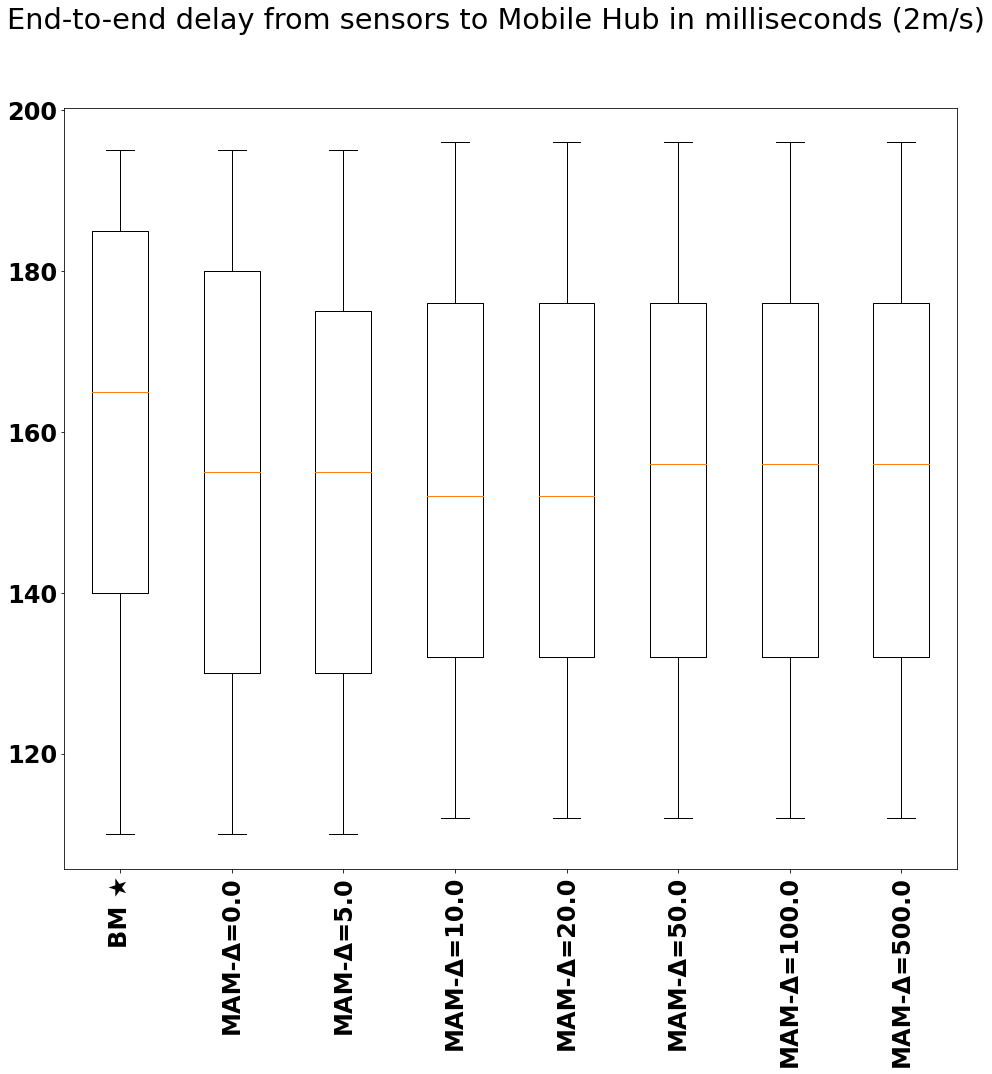

In [30]:
def explodeHistogramData(histogram):
    a = []

    i = 0
    for aa in histogram.binedges[:-1]:
        for j in range(1,histogram.binvalues[i].astype(np.int)):
            a.append(aa)
        i = i + 1
    return a

def getBoxPlotData(labels, bp):
    rows_list = []

    for i in range(len(labels)):
        dict1 = {}
        dict1['label'] = labels[i]
        dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
        dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
        dict1['median'] = bp['medians'][i].get_ydata()[1]
        dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
        dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
        rows_list.append(dict1)

    return pd.DataFrame(rows_list)

# Create a figure instance
fig = plt.figure(1, figsize=(16, 14))

# Create an axes instance
ax = fig.add_subplot(111)

bmesh2mpsData = explodeHistogramData(getHistogramData(histogramName='realDataEndToEndDelay:histogram', 
                        runData=getRunData(findBluetoothRelayRun(speed=2, configName='MAM50-BMRELAY'))))
    
data_to_plot_2ms = [bmesh2mpsData]
labels = ['BM ★']

for d in allDeltas:
    data_to_plot_2ms.append(explodeHistogramData(getHistogramData(histogramName='realDataEndToEndDelay:histogram', 
                        runData=getRunData(findMAMRelayRun(speed=2, delta=d, configName='MAM50-MAMRELAY')))))
    labels.append('MAM-Δ=' + str(d))

# Create the boxplot
bp = ax.boxplot(data_to_plot_2ms, showfliers=False)

ax.set_xticklabels(labels)

speed = 2
plt.suptitle('End-to-end delay from sensors to Mobile Hub in milliseconds (' + str(speed) + 'm/s)')

plt.xticks(rotation='90.0')

# Save the figure
fig.savefig('fig1.png', bbox_inches='tight')

getBoxPlotData(labels, bp)

,label,lower_whisker,lower_quartile,median,upper_quartile,upper_whisker
0,BM ★,38.0,70.0,90.0,112.0,140.0
1,MAM-Δ=0.0,0.0,64.0,82.0,109.0,140.0
2,MAM-Δ=5.0,0.0,60.0,80.0,104.0,140.0
3,MAM-Δ=10.0,0.0,60.0,76.0,100.0,140.0
4,MAM-Δ=20.0,0.0,58.0,72.0,98.0,140.0
5,MAM-Δ=50.0,0.0,54.0,70.0,92.0,140.0
6,MAM-Δ=100.0,0.0,54.0,72.0,94.0,140.0
7,MAM-Δ=500.0,0.0,54.0,70.0,94.0,140.0


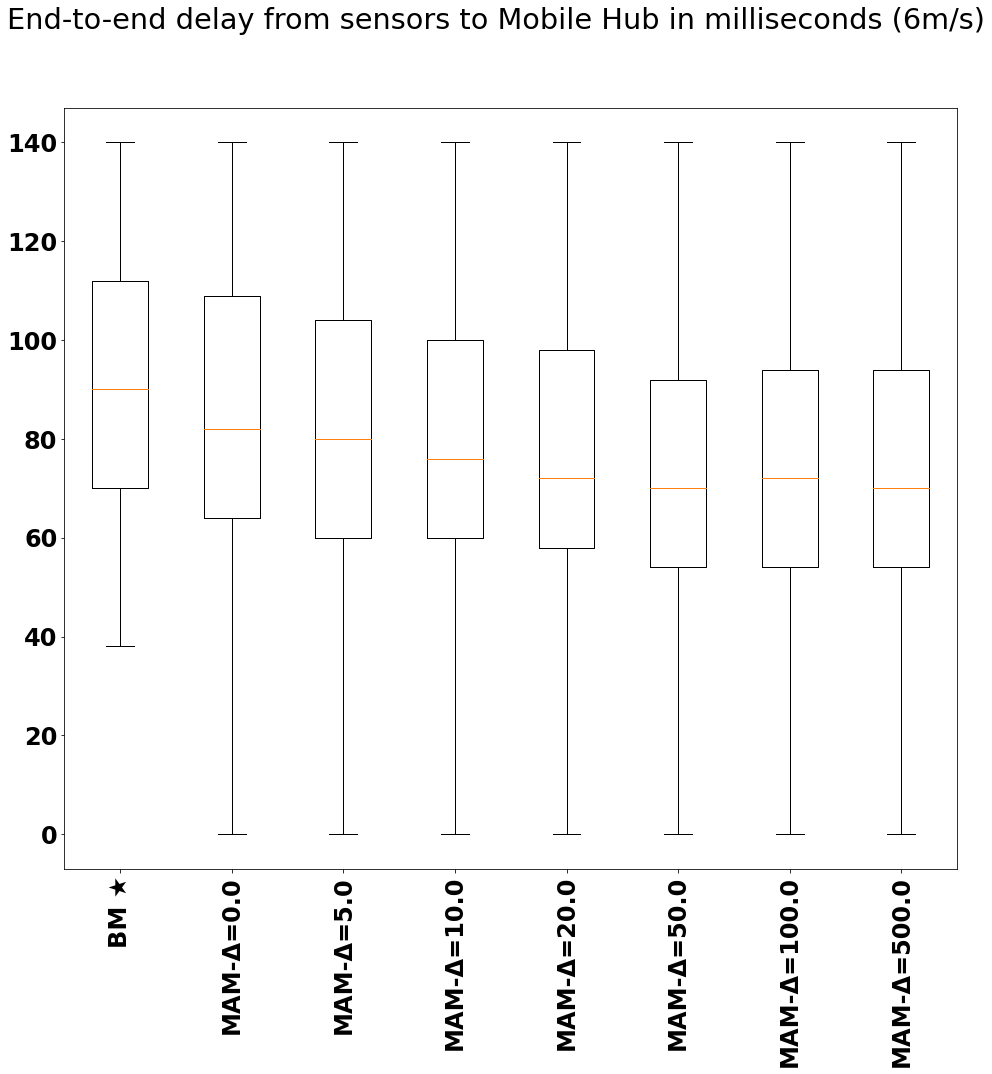

In [31]:
# Create a figure instance
fig = plt.figure(1, figsize=(16, 14))

# Create an axes instance
ax = fig.add_subplot(111)

bmesh6mpsData = explodeHistogramData(getHistogramData(histogramName='realDataEndToEndDelay:histogram', 
                        runData=getRunData(findBluetoothRelayRun(speed=6, configName='MAM50-BMRELAY'))))

data_to_plot_6ms = [bmesh6mpsData]
labels = ['BM ★']

for d in allDeltas:
    data_to_plot_6ms.append(explodeHistogramData(getHistogramData(histogramName='realDataEndToEndDelay:histogram', 
                        runData=getRunData(findMAMRelayRun(speed=6, delta=d, configName='MAM50-MAMRELAY')))))
    labels.append('MAM-Δ=' + str(d))

# Create the boxplot
bp = ax.boxplot(data_to_plot_6ms, showfliers=False)

ax.set_xticklabels(labels)

speed = 6
plt.suptitle('End-to-end delay from sensors to Mobile Hub in milliseconds (' + str(speed) + 'm/s)')

plt.xticks(rotation='90.0')

# Save the figure
fig.savefig('fig2.png', bbox_inches='tight')

getBoxPlotData(labels, bp)

,label,lower_whisker,lower_quartile,median,upper_quartile,upper_whisker
0,BM ★,0.0,30.0,42.0,57.0,57.0
1,MAM-Δ=0.0,0.0,30.0,45.0,150.0,195.0
2,MAM-Δ=5.0,0.0,25.0,40.0,150.0,195.0
3,MAM-Δ=10.0,0.0,25.0,35.0,55.0,60.0
4,MAM-Δ=20.0,0.0,24.0,33.0,57.0,60.0
5,MAM-Δ=50.0,0.0,24.0,30.0,51.0,60.0
6,MAM-Δ=100.0,0.0,24.0,33.0,54.0,60.0
7,MAM-Δ=500.0,0.0,24.0,33.0,54.0,60.0


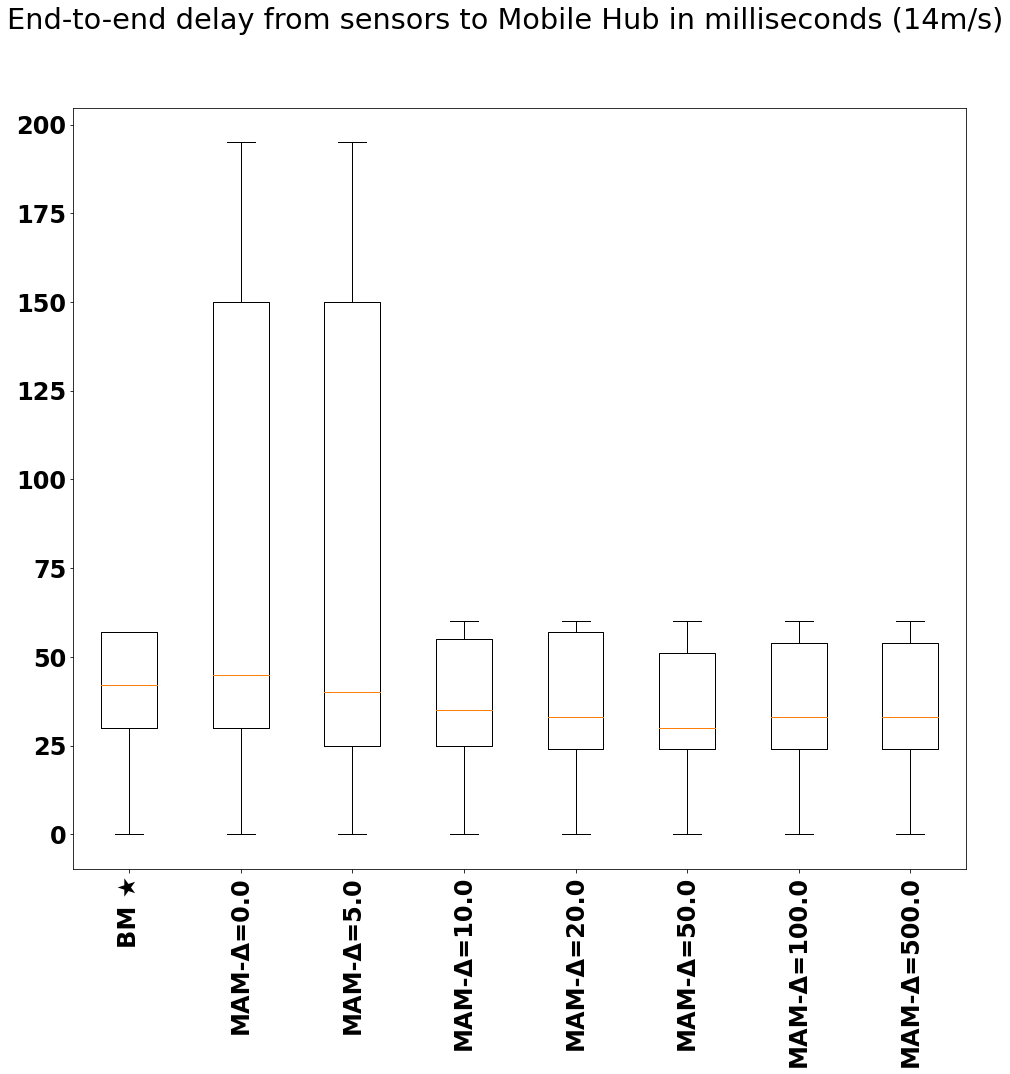

In [32]:
bmesh14mpsData = explodeHistogramData(getHistogramData(histogramName='realDataEndToEndDelay:histogram', 
                        runData=getRunData(findBluetoothRelayRun(speed=14, configName='MAM50-BMRELAY'))))
    
    
# Create a figure instance
fig = plt.figure(1, figsize=(16, 14))

# Create an axes instance
ax = fig.add_subplot(111)

data_to_plot_14ms = [bmesh14mpsData]
labels = ['BM ★']

for d in allDeltas:
    data_to_plot_14ms.append(explodeHistogramData(getHistogramData(histogramName='realDataEndToEndDelay:histogram', 
                        runData=getRunData(findMAMRelayRun(speed=14, delta=d, configName='MAM50-MAMRELAY')))))
    labels.append('MAM-Δ=' + str(d))

# Create the boxplot
bp = ax.boxplot(data_to_plot_14ms, showfliers=False)

ax.set_xticklabels(labels)

speed = 14
plt.suptitle('End-to-end delay from sensors to Mobile Hub in milliseconds (' + str(speed) + 'm/s)')


plt.xticks(rotation='90.0')

# Save the figure
fig.savefig('fig3.png', bbox_inches='tight')

getBoxPlotData(labels, bp)

In [33]:
def getEnergyConsumptionData(speed):
    energyConsumptionSumBM = getScalarSum(scalarName='residualEnergyCapacity:last', 
                            runData=getRunData(findBluetoothRelayRun(speed=speed, configName='MAM50-BMRELAY')))


    labels = ['BM ★']
    values = [-energyConsumptionSum]

    for d in allDeltas:
        values.append(-getScalarSum(scalarName='residualEnergyCapacity:last', 
                            runData=getRunData(findMAMRelayRun(speed=speed, delta=d, configName='MAM50-MAMRELAY'))))
        labels.append('MAM-Δ=' + str(d))
    return [labels, values]

def getBarChartData(labels, values):
    rows_list = []
    
    isDict = type(values) is dict
    
    if not isDict:
        for i in range(len(labels)):
            dict1 = {}
            dict1['label'] = labels[i]
            dict1['value'] = values[i]

            rows_list.append(dict1)
    else:
        for key in values:
            row = values[key]
            
            i = 0
            for ld in labels:
                dict1 = {}
                dict1['label'] = key + " - " + ld[0]
                dict1['value'] = row[i]
                rows_list.append(dict1)
                i = i + 1
        
    return pd.DataFrame(rows_list)

[labels, values] = getEnergyConsumptionData(2)
getBarChartData(labels, values)

,label,value
0,BM ★,24.707693
1,MAM-Δ=0.0,21.580170
2,MAM-Δ=5.0,23.931372
3,MAM-Δ=10.0,23.588629
4,MAM-Δ=20.0,25.253308
5,MAM-Δ=50.0,25.318586
6,MAM-Δ=100.0,25.851065
7,MAM-Δ=500.0,24.837587


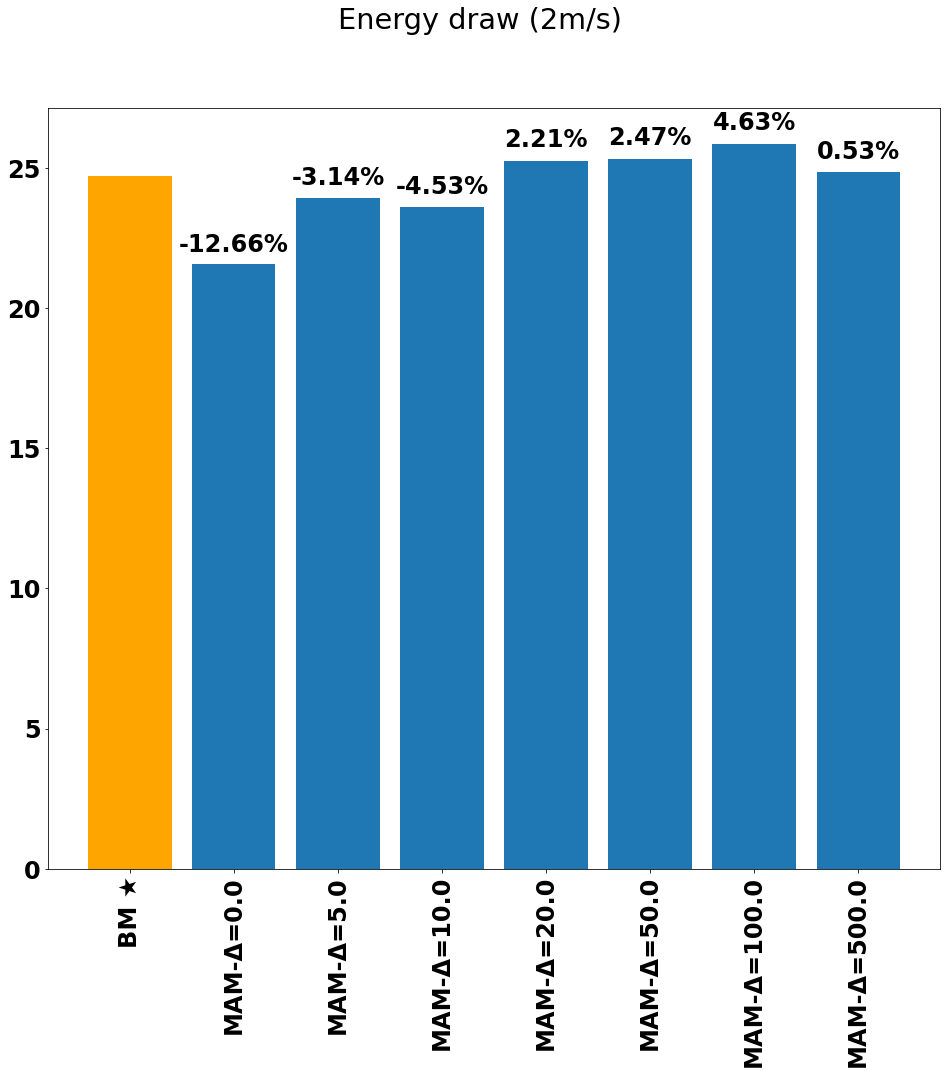

In [34]:
def plotEnergyConsumptionData(labels, values, speed, imageIdx):
    # Create a figure instance
    fig = plt.figure(1, figsize=(16, 14))

    # Create an axes instance
    ax = fig.add_subplot(111)

    # Create the barchart
    bp = ax.bar(labels, values)
    bp[0].set_color('orange')
        
    i = 0
    for p in bp.patches:
        if i > 0:
            width = p.get_width()
            height = p.get_height()
            x, y = p.get_xy() 
            perc = (values[i]-values[0])/values[0]
            ax.annotate(f'{perc:.2%}', (x + width/2, y + height*1.02), ha='center')
        i = i + 1

    plt.suptitle('Energy draw (' + str(speed) + 'm/s)')
    plt.xticks(rotation='90.0')

    # Save the figure
    fig.savefig('fig' + str(imageIdx) + '.png', bbox_inches='tight')
    
plotEnergyConsumptionData(labels, values, 2, 4)

In [35]:
[labels, values] = getEnergyConsumptionData(6)
getBarChartData(labels, values)

,label,value
0,BM ★,24.707693
1,MAM-Δ=0.0,22.120916
2,MAM-Δ=5.0,23.624083
3,MAM-Δ=10.0,24.666133
4,MAM-Δ=20.0,26.849895
5,MAM-Δ=50.0,27.248872
6,MAM-Δ=100.0,27.401957
7,MAM-Δ=500.0,27.242832


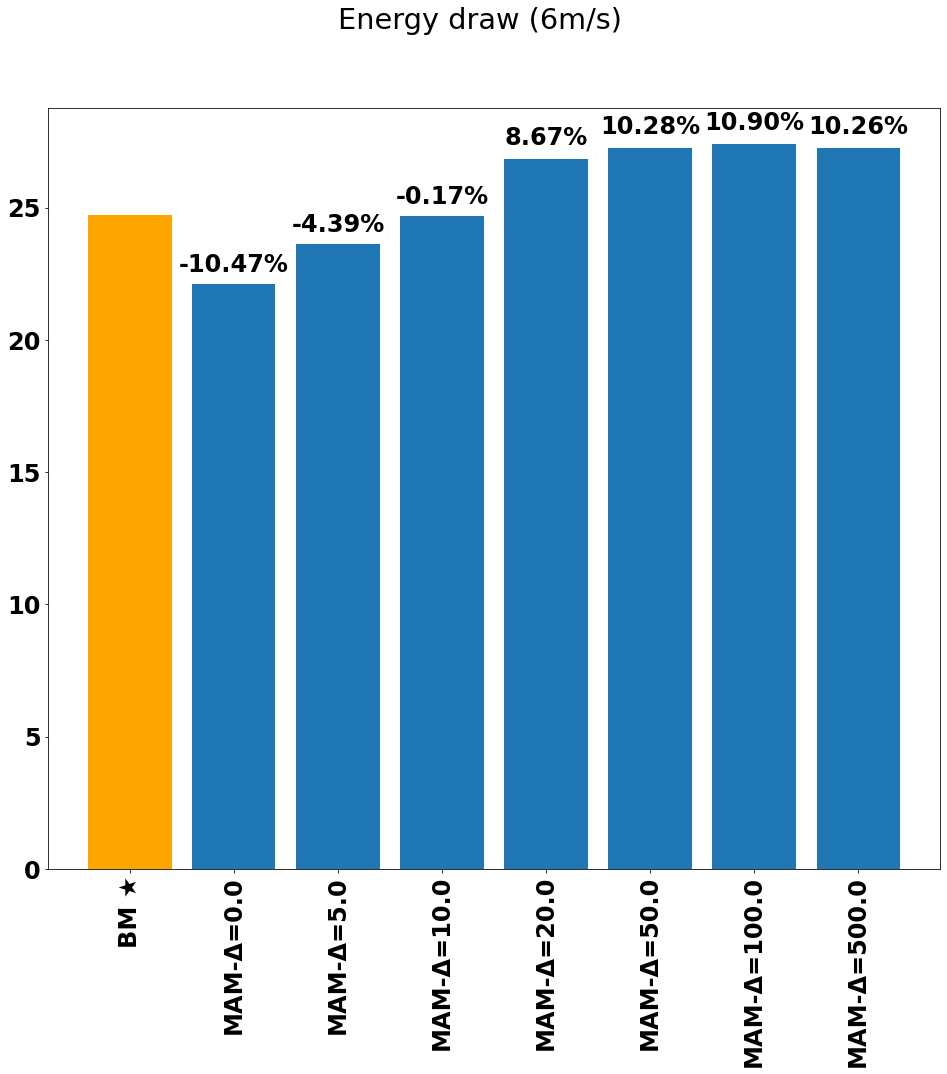

In [36]:
plotEnergyConsumptionData(labels, values, 6, 5)

In [37]:
[labels, values] = getEnergyConsumptionData(14)
getBarChartData(labels, values)

,label,value
0,BM ★,24.707693
1,MAM-Δ=0.0,20.538765
2,MAM-Δ=5.0,20.488957
3,MAM-Δ=10.0,21.424691
4,MAM-Δ=20.0,22.574431
5,MAM-Δ=50.0,23.669533
6,MAM-Δ=100.0,23.075450
7,MAM-Δ=500.0,23.361176


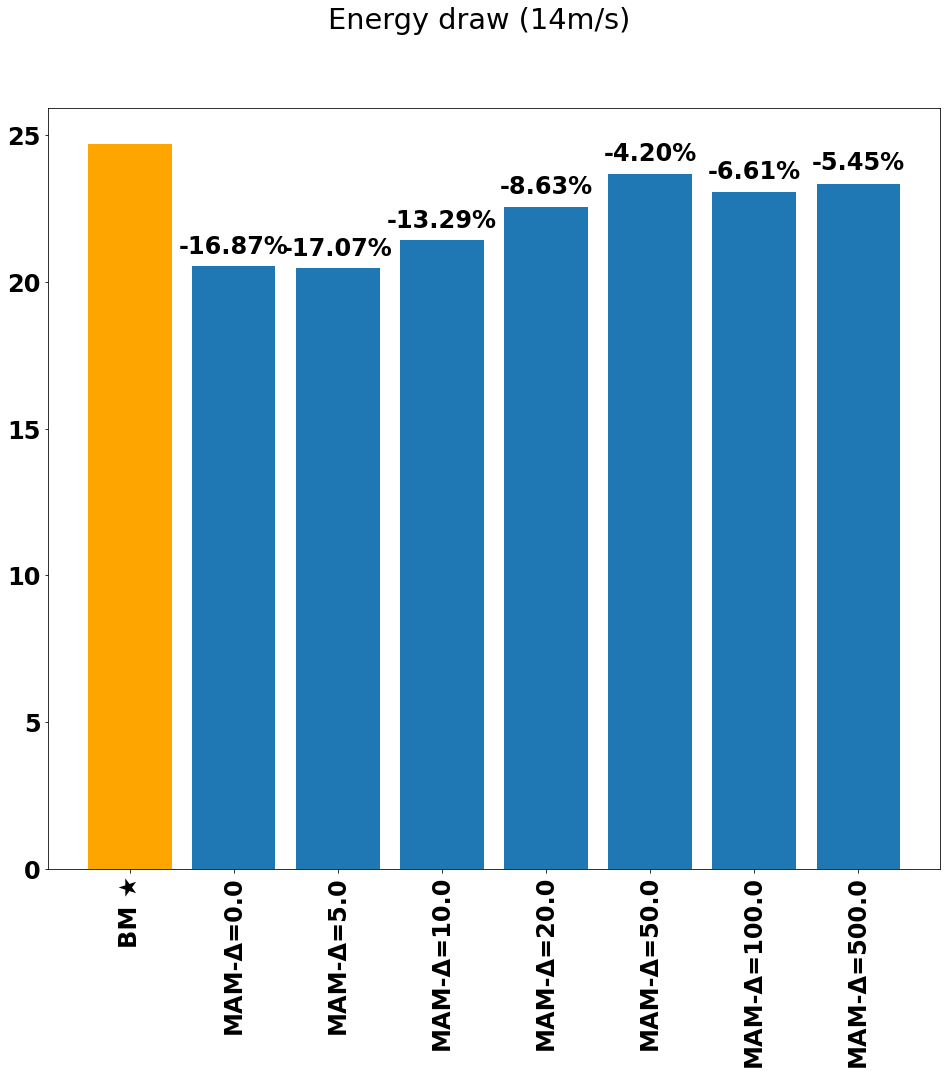

In [38]:
plotEnergyConsumptionData(labels, values, 14, 6)

In [39]:
def getCollectorPacketsReceivedData(speed):
    bmData = getUniqueScalarValue(scalarName='unique data packets bytes received', 
                            scalarData=getCollectorRunScalars(findBluetoothRelayRun(speed=speed, configName='MAM50-BMRELAY')))

    bmRepeatedData = getUniqueScalarValue(scalarName='repeated data packets bytes received', 
                            scalarData=getCollectorRunScalars(findBluetoothRelayRun(speed=speed, configName='MAM50-BMRELAY')))

    labels = [['unique',u'#348ABD'], ['repeated',u'#A60628']]
    values = dict()
    values['BM ★'] = [bmData, bmRepeatedData]
    #repeatedValues = [bmRepeatedData]

    for d in allDeltas:
        data = getUniqueScalarValue(scalarName='unique data packets bytes received', 
                            scalarData=getCollectorRunScalars(findMAMRelayRun(speed=speed, delta=d, configName='MAM50-MAMRELAY')))
        repeatedData = getUniqueScalarValue(scalarName='repeated data packets bytes received', 
                            scalarData=getCollectorRunScalars(findMAMRelayRun(speed=speed, delta=d, configName='MAM50-MAMRELAY')))
        values['MAM-Δ=' + str(d)] = [data,repeatedData]
    return [labels, values]

def plotPacketsReceivedData(labels, values, speed, imageIdx):
    # Create a figure instance
    fig = plt.figure(1, figsize=(16, 14))
    
    # Create an axes instance
    ax = fig.add_subplot(111)

    ax.set_xticklabels([], fontsize = 24)

    bp = []
    
    # Create the barchart
    i = 0
    for key,vals in values.items():
        j = len(vals)
        temp = sum(vals)
        for val in reversed(vals):
            tempBp = ax.bar(i, temp, color=labels[j - 1][1])
            
            if j == len(vals):
                bp.append(tempBp) # Only add the sum to the bp patches
            
            temp = temp - val
            j = j - 1
        i = i + 1


    labelNames = list()
    colors = dict()
    for labelData in labels:
        labelNames.append(labelData[0])
        colors[labelData[0]] = labelData[1]
        
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labelNames]
    plt.legend(handles, labelNames, prop={'weight': 'bold', 'size': 24})

    #bp[0].set_color('orange')
    
    i = 0
    for c in bp:
        for p in c.patches:
            if i > 0:
                width = p.get_width()
                height = p.get_height()
                x, y = p.get_xy() 
                vvalues = list(values.values())
                perc = (sum(vvalues[i])-(vvalues[0][0]))/(vvalues[0][0])
                ax.annotate(f'{perc:.2%}', (x + width/2, y + height*1.02), ha='center')
            i = i + 1

    plt.suptitle('M-Hub Received packets in bytes (' + str(speed) + 'm/s)', fontproperties={'weight': 'bold', 'size': 24})
    plt.xticks(range(len(values)), values.keys(), rotation='90.0')

    # Save the figure
    fig.savefig('fig' + str(imageIdx) + '.png', bbox_inches='tight')
    


In [40]:
[labels, values] = getCollectorPacketsReceivedData(2)


In [41]:
getBarChartData(labels, values)

,label,value
0,BM ★ - unique,14300.0
1,BM ★ - repeated,6820.0
2,MAM-Δ=0.0 - unique,10527.0
3,MAM-Δ=0.0 - repeated,0.0
4,MAM-Δ=5.0 - unique,14674.0
5,MAM-Δ=5.0 - repeated,0.0
6,MAM-Δ=10.0 - unique,21637.0
7,MAM-Δ=10.0 - repeated,0.0
8,MAM-Δ=20.0 - unique,36179.0
9,MAM-Δ=20.0 - repeated,0.0


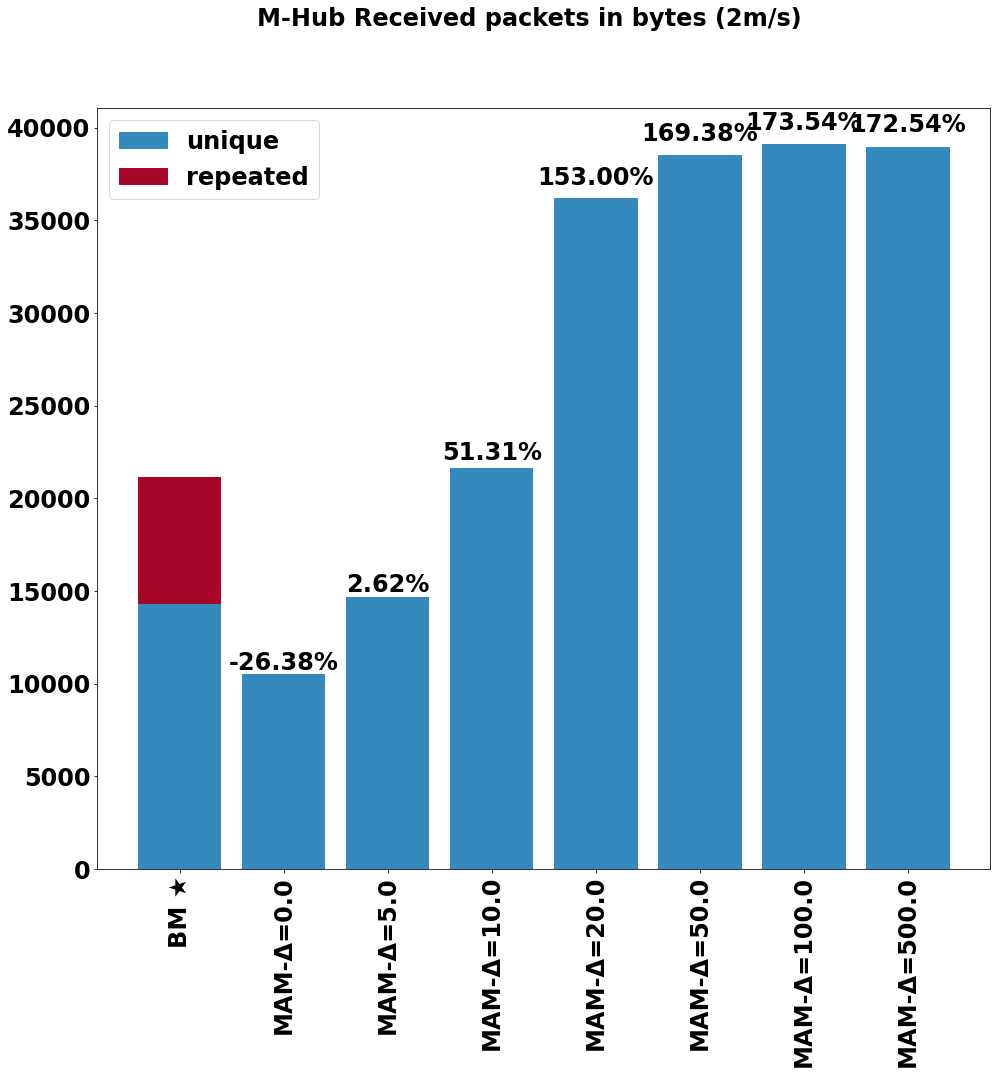

In [42]:
plotPacketsReceivedData(labels, values, 2, 7)

In [43]:
[labels, values] = getCollectorPacketsReceivedData(6)
getBarChartData(labels, values)

,label,value
0,BM ★ - unique,17479.0
1,BM ★ - repeated,18546.0
2,MAM-Δ=0.0 - unique,11396.0
3,MAM-Δ=0.0 - repeated,0.0
4,MAM-Δ=5.0 - unique,13915.0
5,MAM-Δ=5.0 - repeated,0.0
6,MAM-Δ=10.0 - unique,20405.0
7,MAM-Δ=10.0 - repeated,0.0
8,MAM-Δ=20.0 - unique,27060.0
9,MAM-Δ=20.0 - repeated,0.0


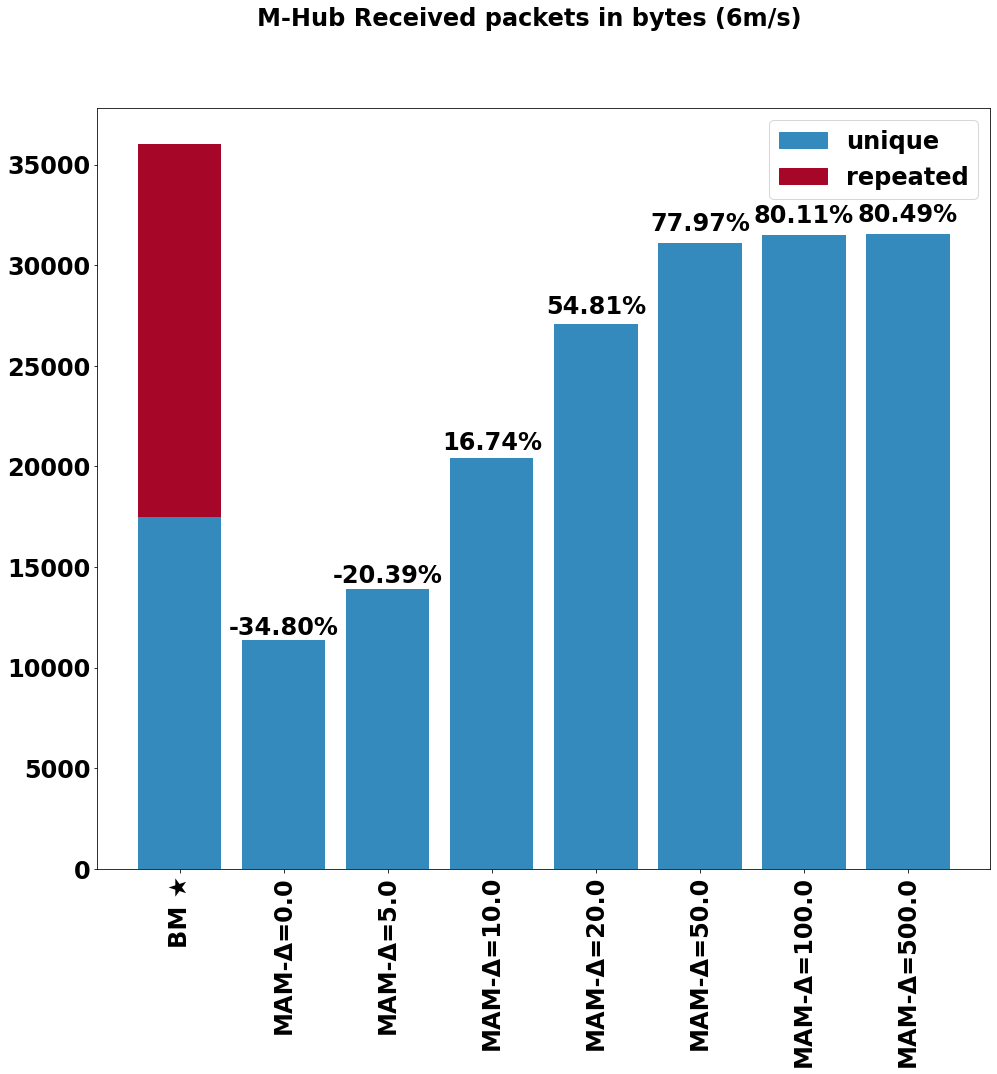

In [44]:
plotPacketsReceivedData(labels, values, 6, 8)

In [45]:
[labels, values] = getCollectorPacketsReceivedData(14)
getBarChartData(labels, values)

,label,value
0,BM ★ - unique,9108.0
1,BM ★ - repeated,9295.0
2,MAM-Δ=0.0 - unique,6798.0
3,MAM-Δ=0.0 - repeated,0.0
4,MAM-Δ=5.0 - unique,7920.0
5,MAM-Δ=5.0 - repeated,0.0
6,MAM-Δ=10.0 - unique,11088.0
7,MAM-Δ=10.0 - repeated,0.0
8,MAM-Δ=20.0 - unique,14685.0
9,MAM-Δ=20.0 - repeated,0.0


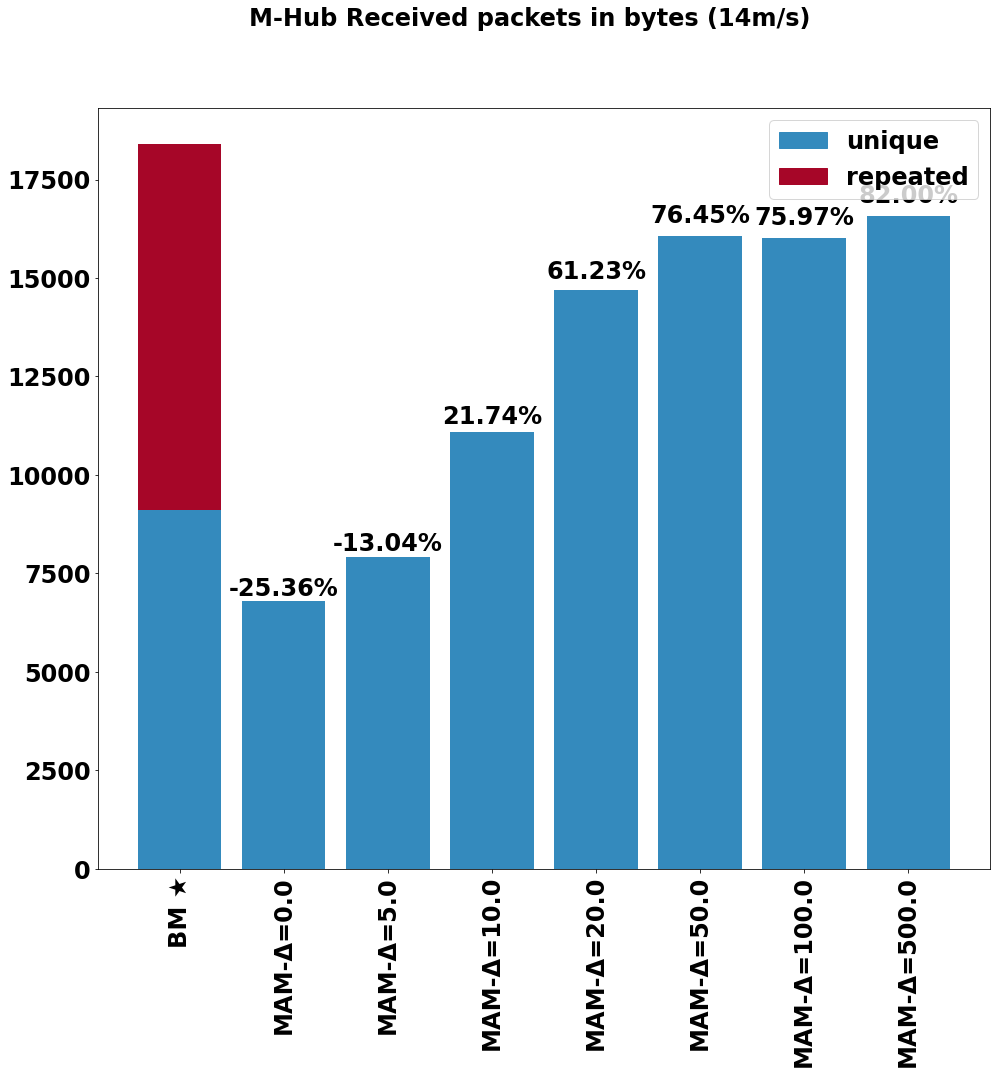

In [46]:
plotPacketsReceivedData(labels, values, 14, 9)

In [47]:
def getReceivedPacketUUIDs(runData):
    packetUUIDs = set()

    data = runData[runData['name'].str.contains("received packet uuids-part1", na=False)]

    i = 1
    while len(data) > 0:
        if len(data) > 1:
            raise Exception('Error - non unique uuid part')

        key = data.iloc[0]['name']
        uuidsPartial = key.split('=')[1].split(',')
        packetUUIDs.update(uuidsPartial)
        i = i + 1
        data = runData[runData['name'].str.contains("received packet uuids-part" + str(i), na=False)]

    return packetUUIDs

def getGeneratedPacketUUIDs(runData):
    packetUUIDs = set()

    data = runData[runData['name'].str.contains("generated packet uuids", na=False)]['name']
    
    data.apply(lambda x: packetUUIDs.update(x.replace('generated packet uuids','').split(',')))
    
    return packetUUIDs

temp = getRunData(findMAMRelayRun(speed=2, delta=5, configName='MAM50-MAMRELAY'))
received = getReceivedPacketUUIDs(temp)
generated = getGeneratedPacketUUIDs(temp)

notReceivedPackets = generated.difference(received)

len(received)/len(generated)*100

24.387568555758683

In [48]:
def getCollectorPacketsUniqueReceivedCount(speed):
    runData = getRunData(findBluetoothRelayRun(speed=speed, configName='MAM50-BMRELAY'))
    bmData = len(getReceivedPacketUUIDs(runData))


    labels = ['BM ★']
    values = [bmData]

    for d in allDeltas:
        runData = getRunData(findMAMRelayRun(speed=speed, delta=d, configName='MAM50-MAMRELAY'))
        values.append(len(getReceivedPacketUUIDs(runData)))
        labels.append('MAM-Δ=' + str(d))
    return [labels, values]

def plotPacketsUniqueReceivedCount(labels, values, speed, imageIdx):
    # Create a figure instance
    fig = plt.figure(1, figsize=(16, 14))

    # Create an axes instance
    ax = fig.add_subplot(111)

    # Create the barchart
    bp = ax.bar(labels, values)
    bp[0].set_color('orange')

    i = 0
    for p in bp.patches:
        if i > 0:
            width = p.get_width()
            height = p.get_height()
            x, y = p.get_xy() 
            perc = (values[i]-values[0])/values[0]
            ax.annotate(f'{perc:.2%}', (x + width/2, y + height*1.02), ha='center')
        i = i + 1
        
    plt.suptitle('M-Hub Received unique data packets count (' + str(speed) + 'm/s)')
    plt.xticks(rotation='90.0')

    # Save the figure
    fig.savefig('fig' + str(imageIdx) + '.png', bbox_inches='tight')

[labels, values] = getCollectorPacketsUniqueReceivedCount(2)
getBarChartData(labels, values)

,label,value
0,BM ★,1300
1,MAM-Δ=0.0,957
2,MAM-Δ=5.0,1334
3,MAM-Δ=10.0,1967
4,MAM-Δ=20.0,3289
5,MAM-Δ=50.0,3502
6,MAM-Δ=100.0,3556
7,MAM-Δ=500.0,3543


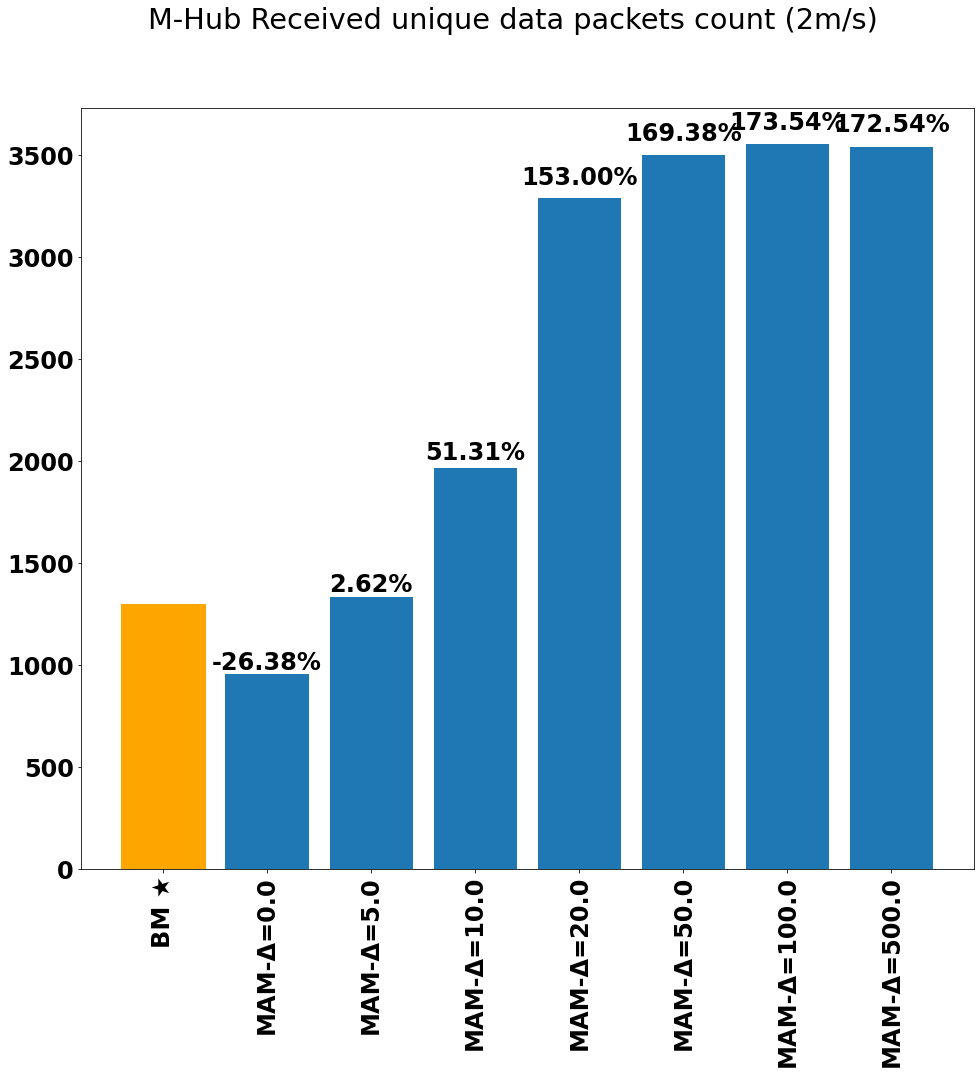

In [49]:
plotPacketsUniqueReceivedCount(labels, values, 2, 10)

In [50]:
[labels, values] = getCollectorPacketsUniqueReceivedCount(6)
getBarChartData(labels, values)

,label,value
0,BM ★,1589
1,MAM-Δ=0.0,1036
2,MAM-Δ=5.0,1265
3,MAM-Δ=10.0,1855
4,MAM-Δ=20.0,2460
5,MAM-Δ=50.0,2828
6,MAM-Δ=100.0,2862
7,MAM-Δ=500.0,2868


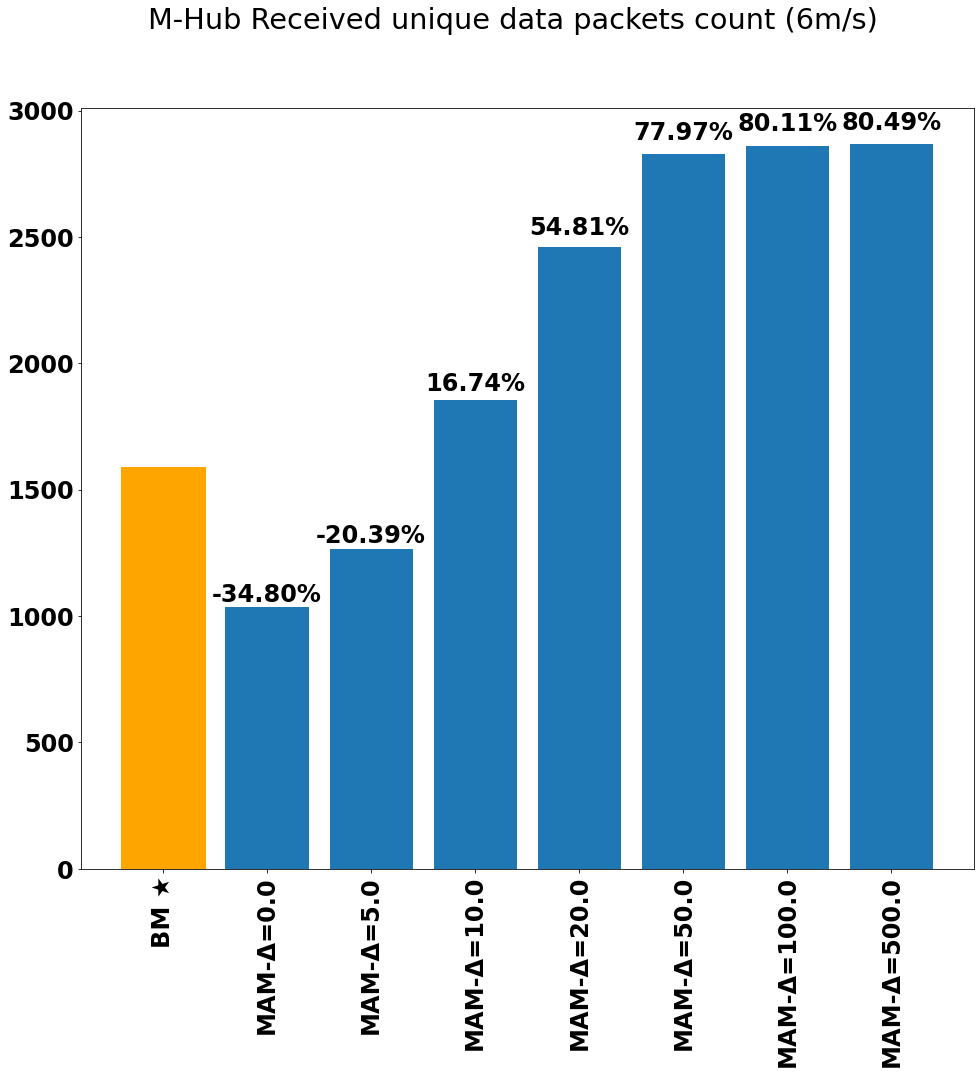

In [51]:
plotPacketsUniqueReceivedCount(labels, values, 6, 11)

In [52]:
[labels, values] = getCollectorPacketsUniqueReceivedCount(14)
getBarChartData(labels, values)

,label,value
0,BM ★,828
1,MAM-Δ=0.0,618
2,MAM-Δ=5.0,720
3,MAM-Δ=10.0,1008
4,MAM-Δ=20.0,1335
5,MAM-Δ=50.0,1461
6,MAM-Δ=100.0,1457
7,MAM-Δ=500.0,1507


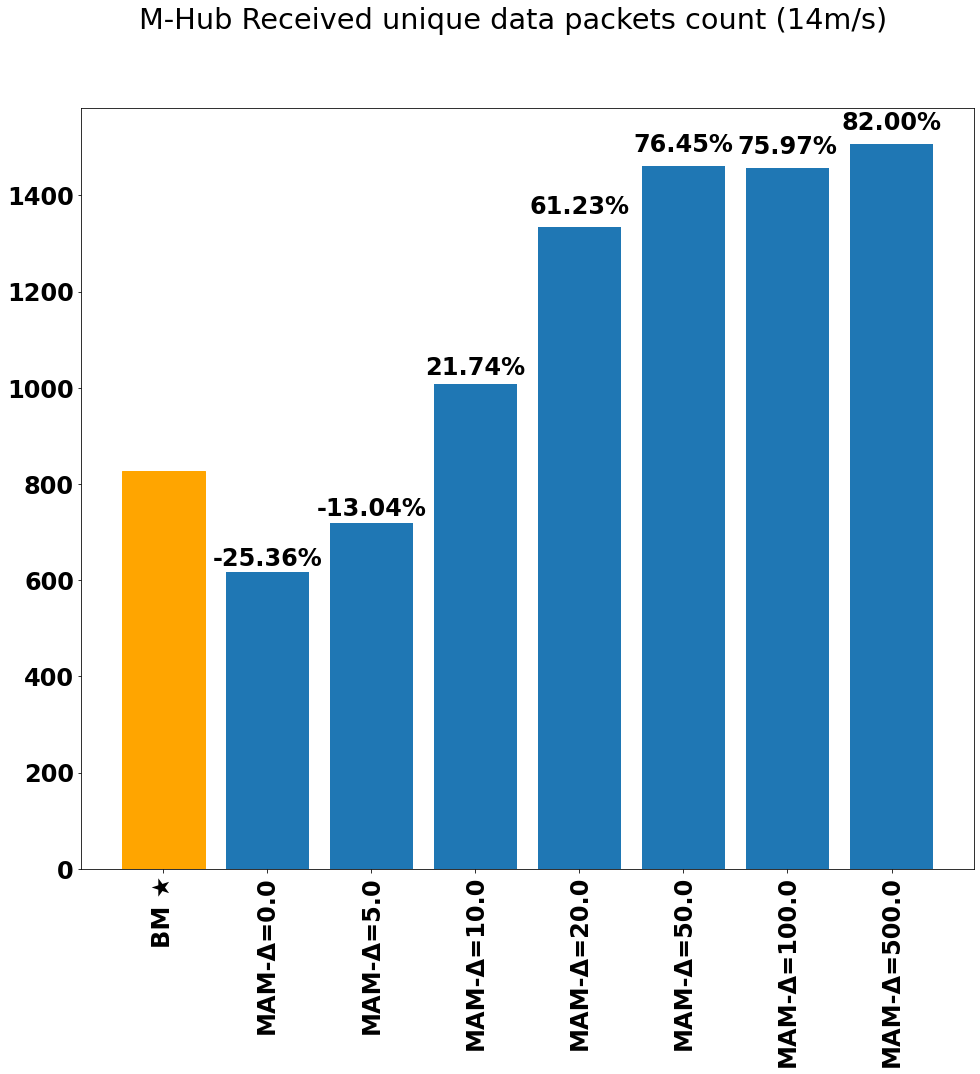

In [53]:
plotPacketsUniqueReceivedCount(labels, values, 14, 12)

In [54]:
def getCollectorPacketsUniqueDeliveryRate(speed):
    runData = getRunData(findBluetoothRelayRun(speed=speed, configName='MAM50-BMRELAY'))
    bmData = len(getReceivedPacketUUIDs(runData))/len(getGeneratedPacketUUIDs(runData))*100


    labels = ['BM ★']
    values = [bmData]

    for d in allDeltas:
        runData = getRunData(findMAMRelayRun(speed=speed, delta=d, configName='MAM50-MAMRELAY'))
        values.append(len(getReceivedPacketUUIDs(runData))/len(getGeneratedPacketUUIDs(runData))*100)
        labels.append('MAM-Δ=' + str(d))
    return [labels, values]

def plotPacketsUniqueDeliveryRate(labels, values, speed, imageIdx):
    # Create a figure instance
    fig = plt.figure(1, figsize=(16, 14))

    # Create an axes instance
    ax = fig.add_subplot(111)

    # Create the barchart
    bp = ax.bar(labels, values)
    bp[0].set_color('orange')

    i = 0
    for p in bp.patches:
        if i > 0:
            width = p.get_width()
            height = p.get_height()
            x, y = p.get_xy() 
            perc = (values[i]-values[0])/values[0]
            ax.annotate(f'{perc:.2%}', (x + width/2, y + height*1.02), ha='center')
        i = i + 1
        
    plt.suptitle('M-Hub delivery rate (uniqueDataReceived/uniqueDataGenerated) in % (' + str(speed) + 'm/s)')
    plt.xticks(rotation='90.0')

    # Save the figure
    fig.savefig('fig' + str(imageIdx) + '.png', bbox_inches='tight')

[labels, values] = getCollectorPacketsUniqueDeliveryRate(2)
getBarChartData(labels, values)

,label,value
0,BM ★,32.402792
1,MAM-Δ=0.0,18.379105
2,MAM-Δ=5.0,24.387569
3,MAM-Δ=10.0,36.897393
4,MAM-Δ=20.0,61.511128
5,MAM-Δ=50.0,68.251803
6,MAM-Δ=100.0,68.635399
7,MAM-Δ=500.0,69.895443


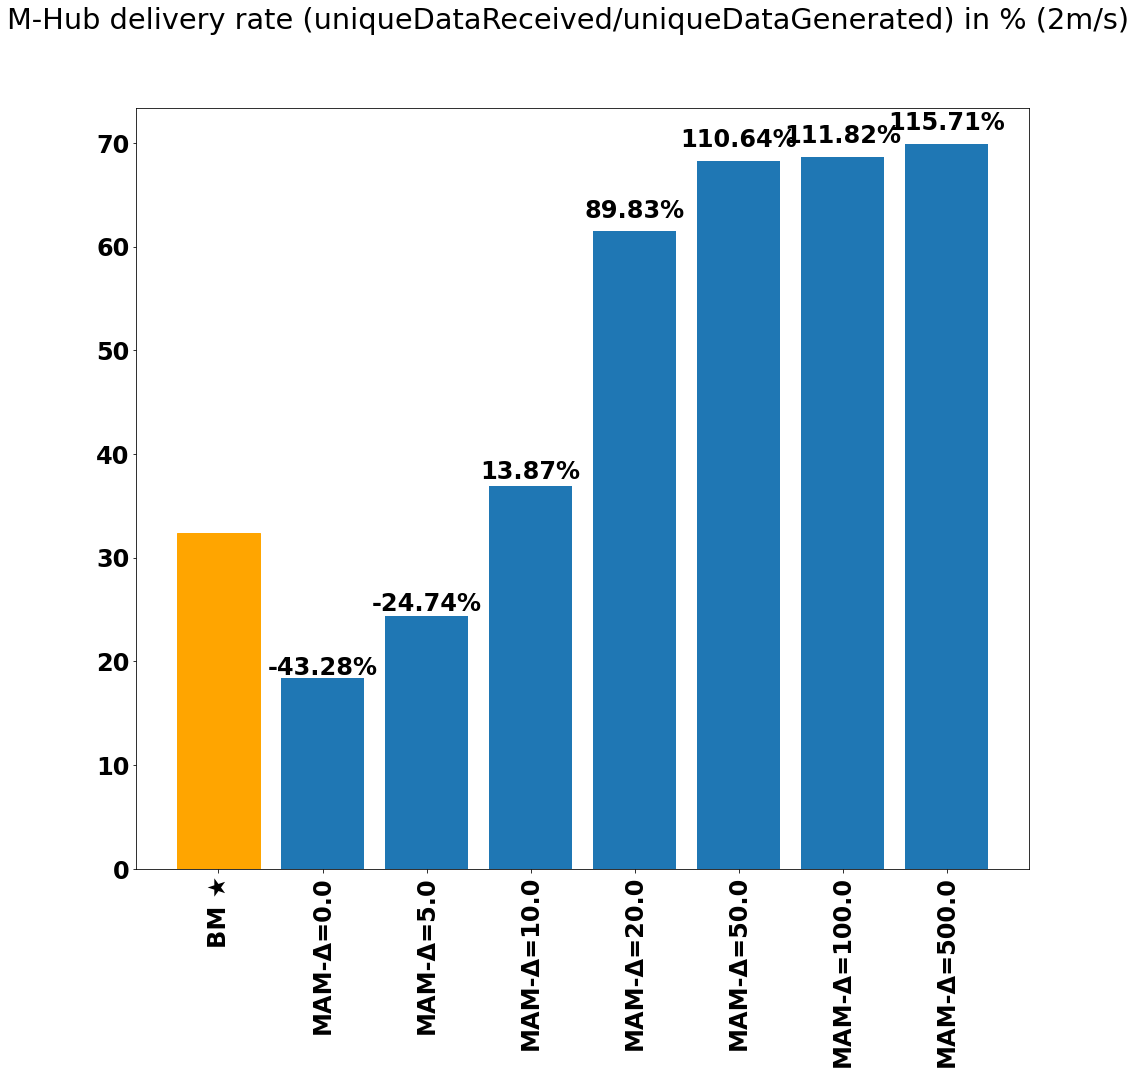

In [55]:
plotPacketsUniqueDeliveryRate(labels, values, 2, 13)

In [56]:
[labels, values] = getCollectorPacketsUniqueDeliveryRate(6)
getBarChartData(labels, values)

,label,value
0,BM ★,31.735570
1,MAM-Δ=0.0,16.851008
2,MAM-Δ=5.0,19.790363
3,MAM-Δ=10.0,28.790936
4,MAM-Δ=20.0,40.235525
5,MAM-Δ=50.0,46.368257
6,MAM-Δ=100.0,46.513896
7,MAM-Δ=500.0,46.832136


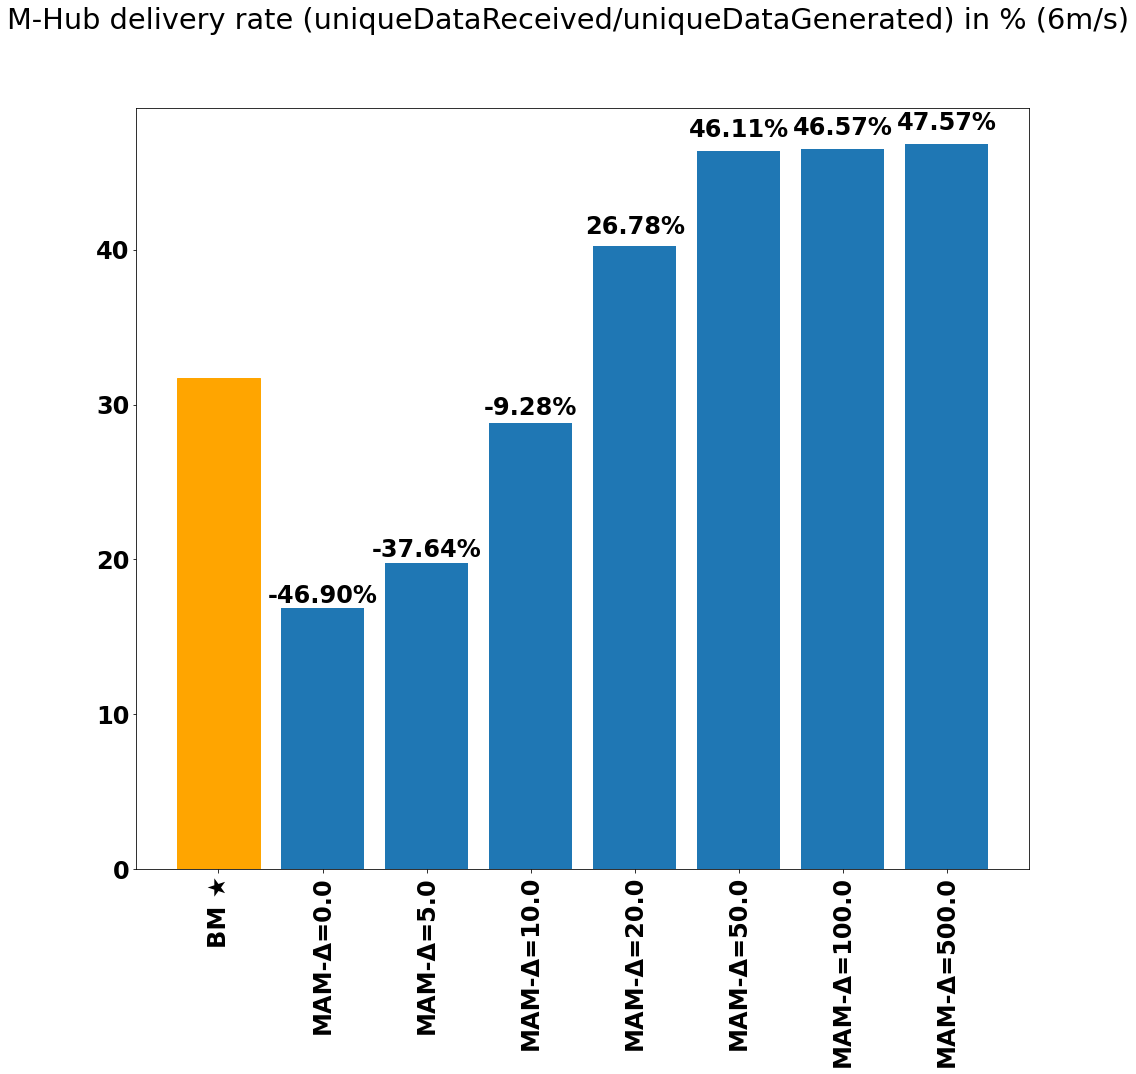

In [57]:

plotPacketsUniqueDeliveryRate(labels, values, 6, 14)

In [58]:
[labels, values] = getCollectorPacketsUniqueDeliveryRate(14)
getBarChartData(labels, values)

,label,value
0,BM ★,27.290705
1,MAM-Δ=0.0,16.267439
2,MAM-Δ=5.0,19.512195
3,MAM-Δ=10.0,27.038627
4,MAM-Δ=20.0,36.188669
5,MAM-Δ=50.0,39.263639
6,MAM-Δ=100.0,41.053818
7,MAM-Δ=500.0,43.180516


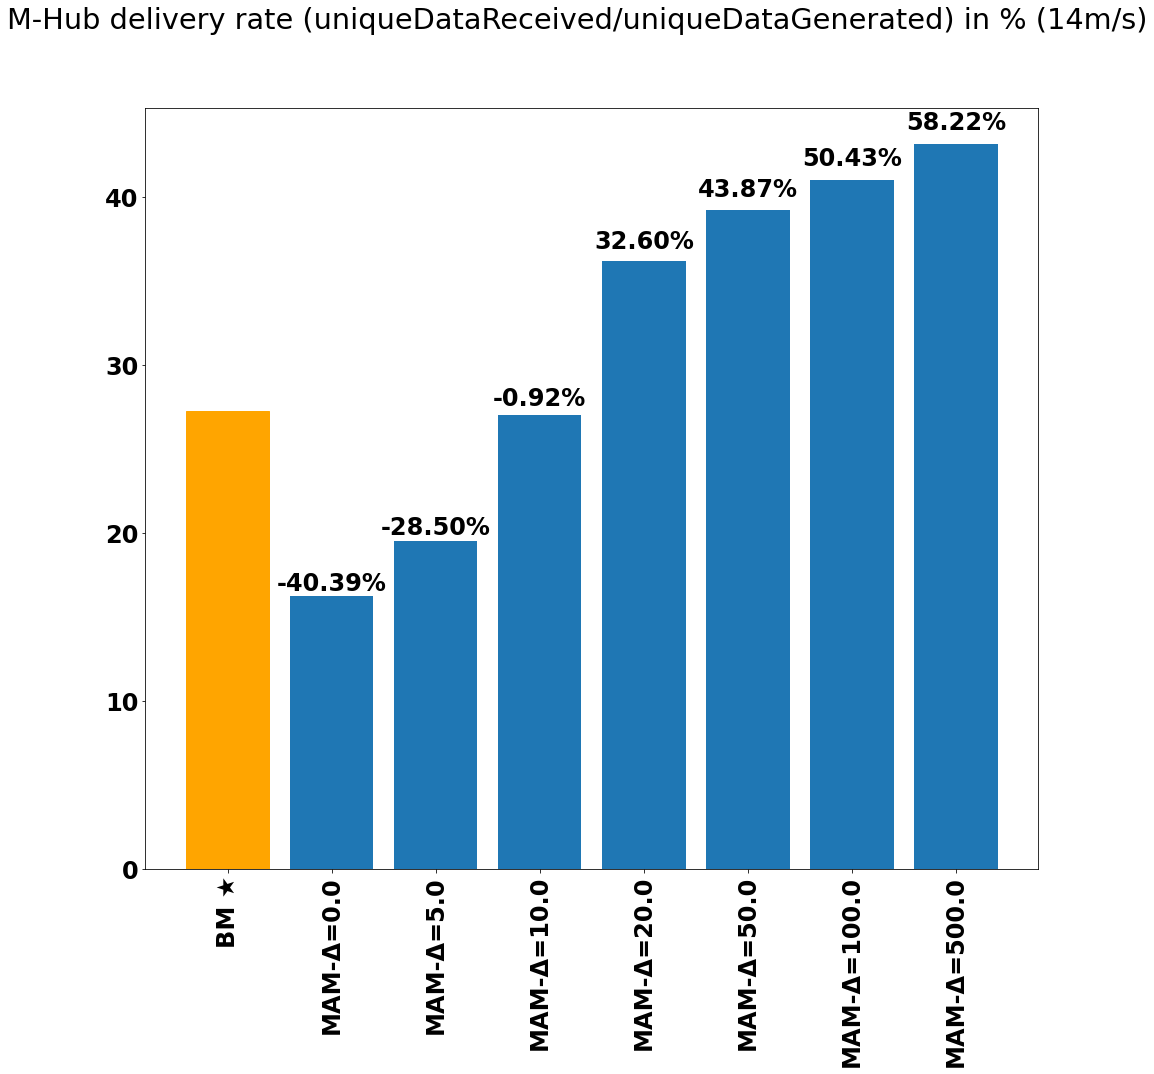

In [59]:

plotPacketsUniqueDeliveryRate(labels, values, 14, 15)